In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False
import warnings
# 忽略所有警告
warnings.filterwarnings("ignore")
df = pd.read_excel('2025-7-13-公众号Python机器学习AI.xlsx')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [ ]:
from sklearn.model_selection import train_test_split

# 划分特征和目标变量
X = df.drop(['Outcome'], axis=1)  
y = df['Outcome']  
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X,  
    y, 
    test_size=0.3, 
    random_state=42, 
    stratify=df['Outcome'] 
)#目标变量是连续变量的时候不要分层抽样，是分类变量的时候才分层抽样

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 初始化随机森林分类模型
model_rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100, 200],       # 树的数量
    'max_depth': [10, 20, None],           # 最大深度
    'min_samples_split': [2, 5, 10],       # 分割节点的最小样本数
    'min_samples_leaf': [1, 2, 4]         # 叶节点的最小样本数
}

# 使用 GridSearchCV 进行网格搜索和 k 折交叉验证
grid_search_rf = GridSearchCV(
    estimator=model_rf,
    param_grid=param_grid_rf,
    scoring='neg_log_loss',  # 评价指标为负对数损失
    cv=5,                    # 5 折交叉验证
    n_jobs=1,                # 使用单线程，避免中文用户名编码问题
    verbose=1                # 输出详细进度信息
)

# 训练模型
grid_search_rf.fit(X_train, y_train)

# 使用最优参数训练模型
best_model_rf = grid_search_rf.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


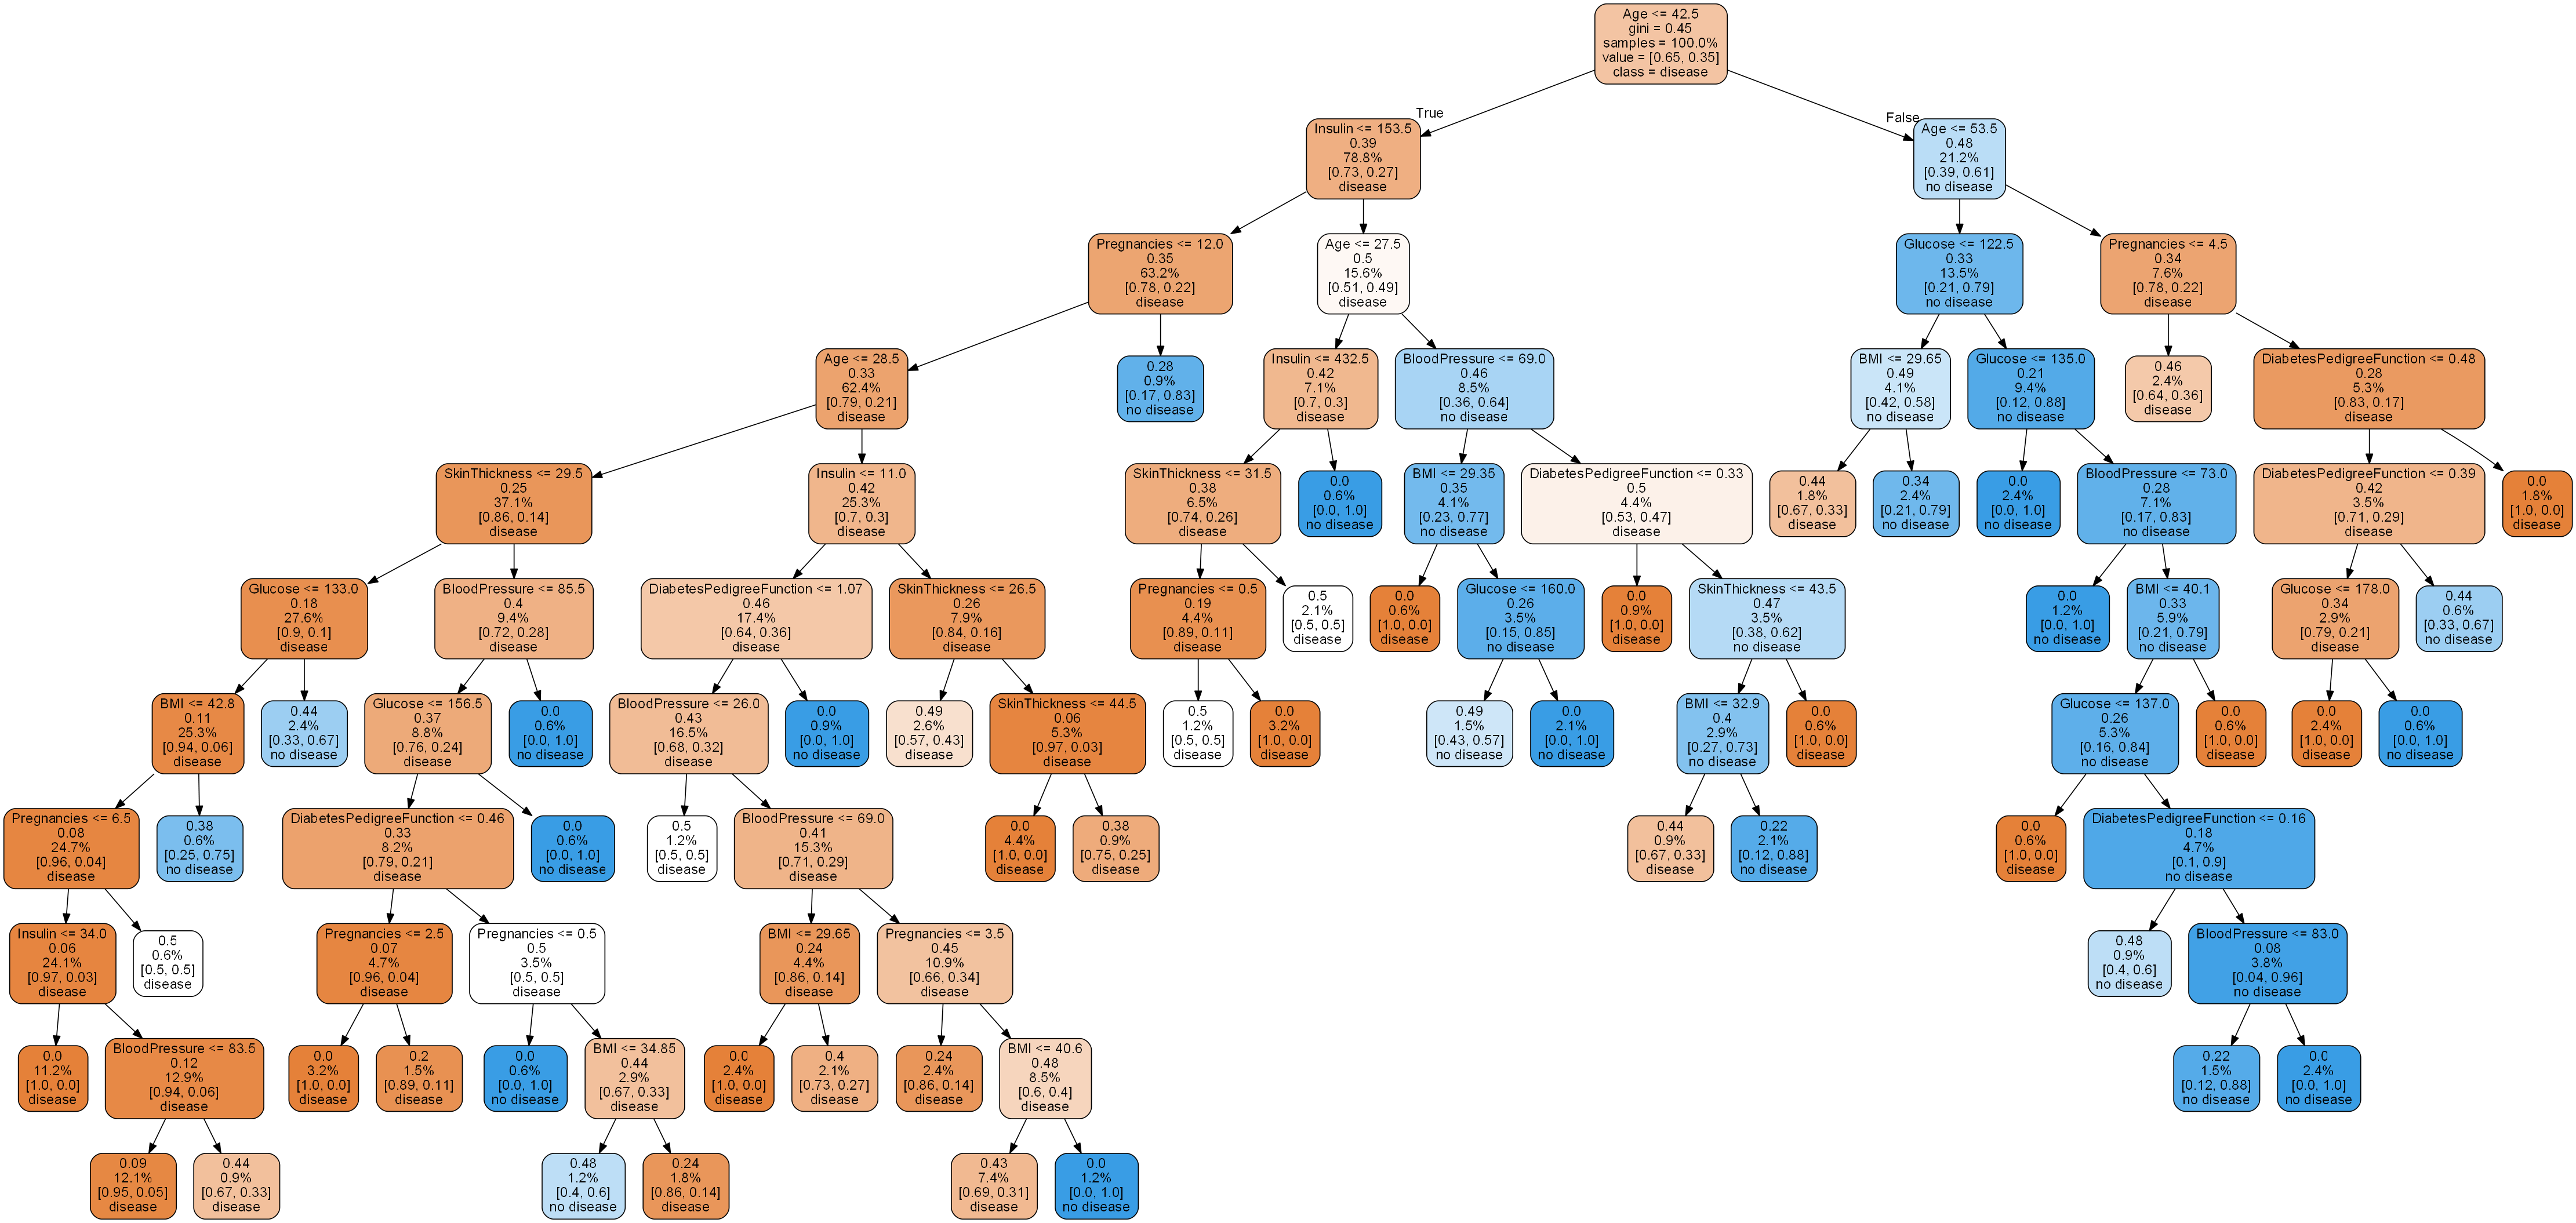

In [5]:
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

# 选择随机森林模型的第一棵树
estimator = best_model_rf.estimators_[1]

# 获取特征名称
feature_names = [i for i in X_train.columns]

# 将目标变量转换为字符串标签
y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

# 导出决策树为 DOT 文件
export_graphviz(estimator, out_file='tree.dot', 
                feature_names=feature_names,
                class_names=y_train_str,
                rounded=True, proportion=True, 
                label='root',
                precision=2, filled=True)

# 使用 Graphviz 将 DOT 文件转换为 PNG 图片
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=120'])

# 显示生成的决策树图像
Image(filename='tree.png')

In [6]:
# 使用 Graphviz 将 DOT 文件转换为 PDF 文件，并设置 DPI 为 1200
call(['dot', '-Tpdf', 'tree.dot', '-o', 'tree.pdf', '-Gdpi=1200'])

0

In [ ]:
# 获取特征重要性
feature_importance = best_model_rf.feature_importances_

# 将特征重要性与特征名称进行匹配
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})

# 按重要性排序
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
1,Glucose,0.324971
5,BMI,0.156792
7,Age,0.125033
6,DiabetesPedigreeFunction,0.101821
0,Pregnancies,0.089400
2,BloodPressure,0.075441
4,Insulin,0.070589
3,SkinThickness,0.055953


In [11]:
import eli5 
from eli5.sklearn import PermutationImportance

# 创建一个 PermutationImportance 实例并拟合模型
# PermutationImportance 是一种模型解释工具，能够通过随机打乱特征值(捣乱法)来评估每个特征对模型性能的贡献
# 这里，model 是已训练好的机器学习模型，x_test 和 y_test 是用于评估模型性能的测试数据和标签
# n_ite迭代多少次
perm = PermutationImportance(best_model_rf, n_iter=20 , scoring='accuracy',random_state = 1314).fit(X_test, y_test)

# 使用 eli5 显示特征的重要性
# 该函数将展示每个特征的贡献度，通过打乱每个特征并观察性能下降的幅度来计算每个特征的重要性
weights = eli5.show_weights(perm, feature_names=X_train.columns.tolist())
weights

Weight,Feature
0.0879 ± 0.0637,Glucose
0.0119 ± 0.0248,BMI
0.0093 ± 0.0202,DiabetesPedigreeFunction
0.0074 ± 0.0176,BloodPressure
-0.0013 ± 0.0129,Insulin
-0.0035 ± 0.0210,Pregnancies
-0.0054 ± 0.0203,Age
-0.0089 ± 0.0141,SkinThickness


In [9]:
# 创建一个 DataFrame 存储特征重要性权重
feature_importances = pd.DataFrame(perm.feature_importances_)
feature_importances.index = X_train.columns.tolist()
feature_importances.columns = ["Weight"]
std = pd.DataFrame(perm.feature_importances_std_)
std.index = X_train.columns.tolist()
std.columns = ["std"]
feature_importances = pd.concat([feature_importances, std], axis=1)
feature_importances.sort_values(by="Weight", ascending=False, inplace=True)
feature_importances

,Weight,std
Glucose,0.087879,0.031873
BMI,0.011905,0.012387
DiabetesPedigreeFunction,0.009307,0.010085
BloodPressure,0.007359,0.008776
Insulin,-0.001299,0.006436
Pregnancies,-0.003463,0.010479
Age,-0.005411,0.010141
SkinThickness,-0.008874,0.007044


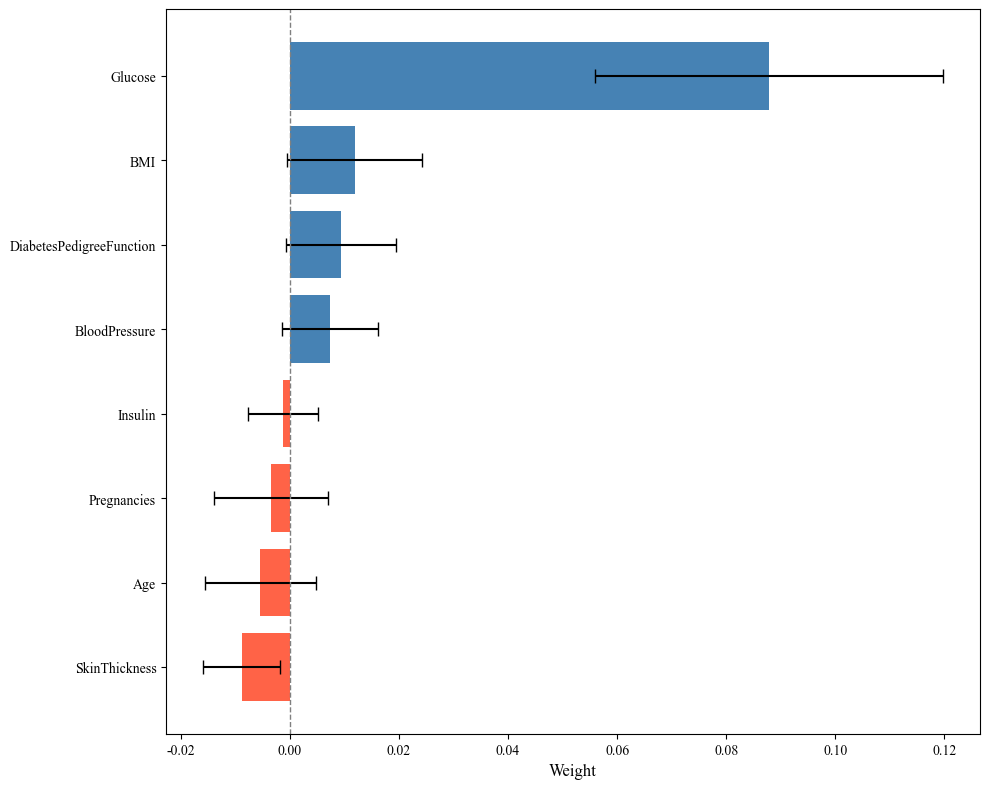

In [10]:
plot_df = feature_importances.iloc[::-1]
# 根据权重的正负创建颜色列表
colors = ['tomato' if x < 0 else 'steelblue' for x in plot_df['Weight']]
fig, ax = plt.subplots(figsize=(10, 8))
# 绘制水平柱状图，并添加误差条
ax.barh(
    plot_df.index,
    plot_df['Weight'],
    xerr=plot_df['std'],
    color=colors,
    align='center',
    capsize=5  # 给误差条添加一个帽子，让它更清晰
)
ax.set_xlabel('Weight', fontsize=12)
# 在 x=0 的位置画一条垂直虚线，用于清晰地区分正负权重
ax.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.savefig("Weight.pdf", format='pdf', bbox_inches='tight', dpi=1200)
# 优化布局
plt.tight_layout()
plt.show()